# Predictive Maintenance

Leader Board 1; score(AUC) 0.54904
Gary Ma, 20413112, bring forward hypothesis, justify hypothesis
Jeff Hou,20413837, bring forward hypothesis, cpu cluster, machine set up

In this notebook, we try to predict whether a machine will fall in a given day with its features in the previous two dates. We strictly follow the requirement, only using the data in the 2 day Observation window to predict machine status of the 1 day Prediction Window.

Instead of pipelining, our exploration is made up of three basic hypothesis and their testing respectively as follows:
1. relationship between machine break-down and time of occurence of errors:
    errors and machine break-down are not linear seperable. But a vague relationship exist when higher order polinomial transformation is used.

2. relationship between machine break-down and each of the five selected type of errors.(only five were selected because of lack of data for the other type of errors):
    Not linearly seperable. No discerable relationship. But a general interesting point is that: machine tend to break down when there are less errors, lower interval of error, and lower variance between the error-occuring interval.
    
3. off the shelf approach: Tree
    Gradient boosting, as a off-the-shelf approach was directly applied, achieving an OK result.
    
we also experimented with SVM, but the outcome was hardly satisfying, overfitting the training set in  a high dimensional space, achieving a very poor result in the validation set.

Because we strictly followed the 2day-observation, 1day prediction window, LSTM is not employed. Which should be because whether a machine break down today definitely is correlated to whether it has broaken down yesterday.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def read_file(train_file,test_file):
    '''
    read in data files
    '''
    with open(train_file) as tr:
        train = pd.read_csv(train_file,header=0,index_col=[0,1],skiprows=[1,2],parse_dates=True)
    with open(test_file) as ts:
        test = pd.read_csv(test_file,header=0,index_col=[0,1],skiprows=[1,2],parse_dates=True)
    return train, test

In [199]:
tr, ts = read_file('./data/train.csv','./data/verification.csv')

In [200]:
# drop columns with NaN more than 50% of the whole length
# drop rows with NaN more than 50% of the whole length
tr = tr.dropna(thresh=int(tr.shape[0]*0.5),axis=1)
tr = tr.dropna(thresh=int(tr.shape[1]*0.5),axis=0)
tr = tr.dropna(subset=['Label'])
tr = tr.fillna(tr.mean())
tr[:5]

1  136110468  136110468.1  136110468.2  136222202  \
Machine Date                                                                    
M040_A1 2015-05-31  11.000000     2168.0    36.169932   582.049346   2.000000   
        2015-06-03   5.127907      336.0    39.068114   518.642504  10.460455   
        2015-06-04   5.127907      860.0   116.230507   667.510109   5.000000   
        2015-06-05   5.127907     3431.0    50.147680   489.273151  13.000000   
        2015-06-06   6.000000     4753.0    35.262732   381.820594  29.000000   

                     136222202.1   136222202.2  136222210   136222210.1  \
Machine Date                                                              
M040_A1 2015-05-31  54422.701916      0.000000   3.000000  16168.214381   
        2015-06-03  22709.796029  13589.060111   6.879022  19660.415717   
        2015-06-04  13321.840334  15517.511932   3.000000  10761.423509   
        2015-06-05  11009.262463  14564.573628   9.000000  17724.287749   
        2015-06-06   5522.663265  10715.884533  33.000000   4994.632282   

                     136222210.2   136224578   136224578.1   136224578.2  \
Machine Date                                                               
M040_A1 2015-05-31   9669.400354    6.000000  10884.619596  21768.843445   
        2015-06-03  14129.255917   40.886963   7215.106505  11043.167892   
        2015-06-04   2622.568843   35.000000   1712.231935   5094.140152   
        2015-06-05  13912.764429   81.000000   1715.634434   4231.365848   
        2015-06-06   8758.845972  154.000000   1086.453012   3600.108155   

                    136224586  136224586.1  136224586.2  136225010  \
Machine Date                                                         
M040_A1 2015-05-31       15.0  5384.429183  8686.993834     4910.0   
        2015-06-03        2.0     0.084161     0.000000        2.0   
        2015-06-04       45.0  1964.509152  4721.077744      372.0   
        2015-06-05       82.0  2127.130568  4429.827390      731.0   
        2015-06-06      189.0   878.242497  2892.275215      659.0   

                    136225010.1  136225010.2  Label  
Machine Date                                         
M040_A1 2015-05-31    17.180931   179.370483  False  
        2015-06-03   240.980366     0.000000  False  
        2015-06-04   231.788741   737.661999  False  
        2015-06-05   236.315779   761.945021   True  
        2015-06-06   261.341649   901.261628  False

In [176]:
# sparse data with few machine broaken down
(tr['Label']==1).sum()/tr.shape[0]

0.07448275862068965

In [177]:
tr.columns

Index(['1', '136110468', '136110468.1', '136110468.2', '136222202',
       '136222202.1', '136222202.2', '136222210', '136222210.1', '136222210.2',
       '136224578', '136224578.1', '136224578.2', '136224586', '136224586.1',
       '136224586.2', '136225010', '136225010.1', '136225010.2', 'Label'],
      dtype='object')

In [20]:
train_tr = tr[tr['Label']]
train_fl = tr[~tr['Label']]
# first intuition is the number of down time counts
count = ['Label']
mean = ['Label']
var = ['Label']
for name in tr.columns:
    if name!='Label':        
        if '.' not in name:
            count.append(name)
        elif '.1' not in name:
            var.append(name)
        elif '.2' not in name:
            mean.append(name)

# First Guess is the number of errors in the past two days is correlated with the break down of today.

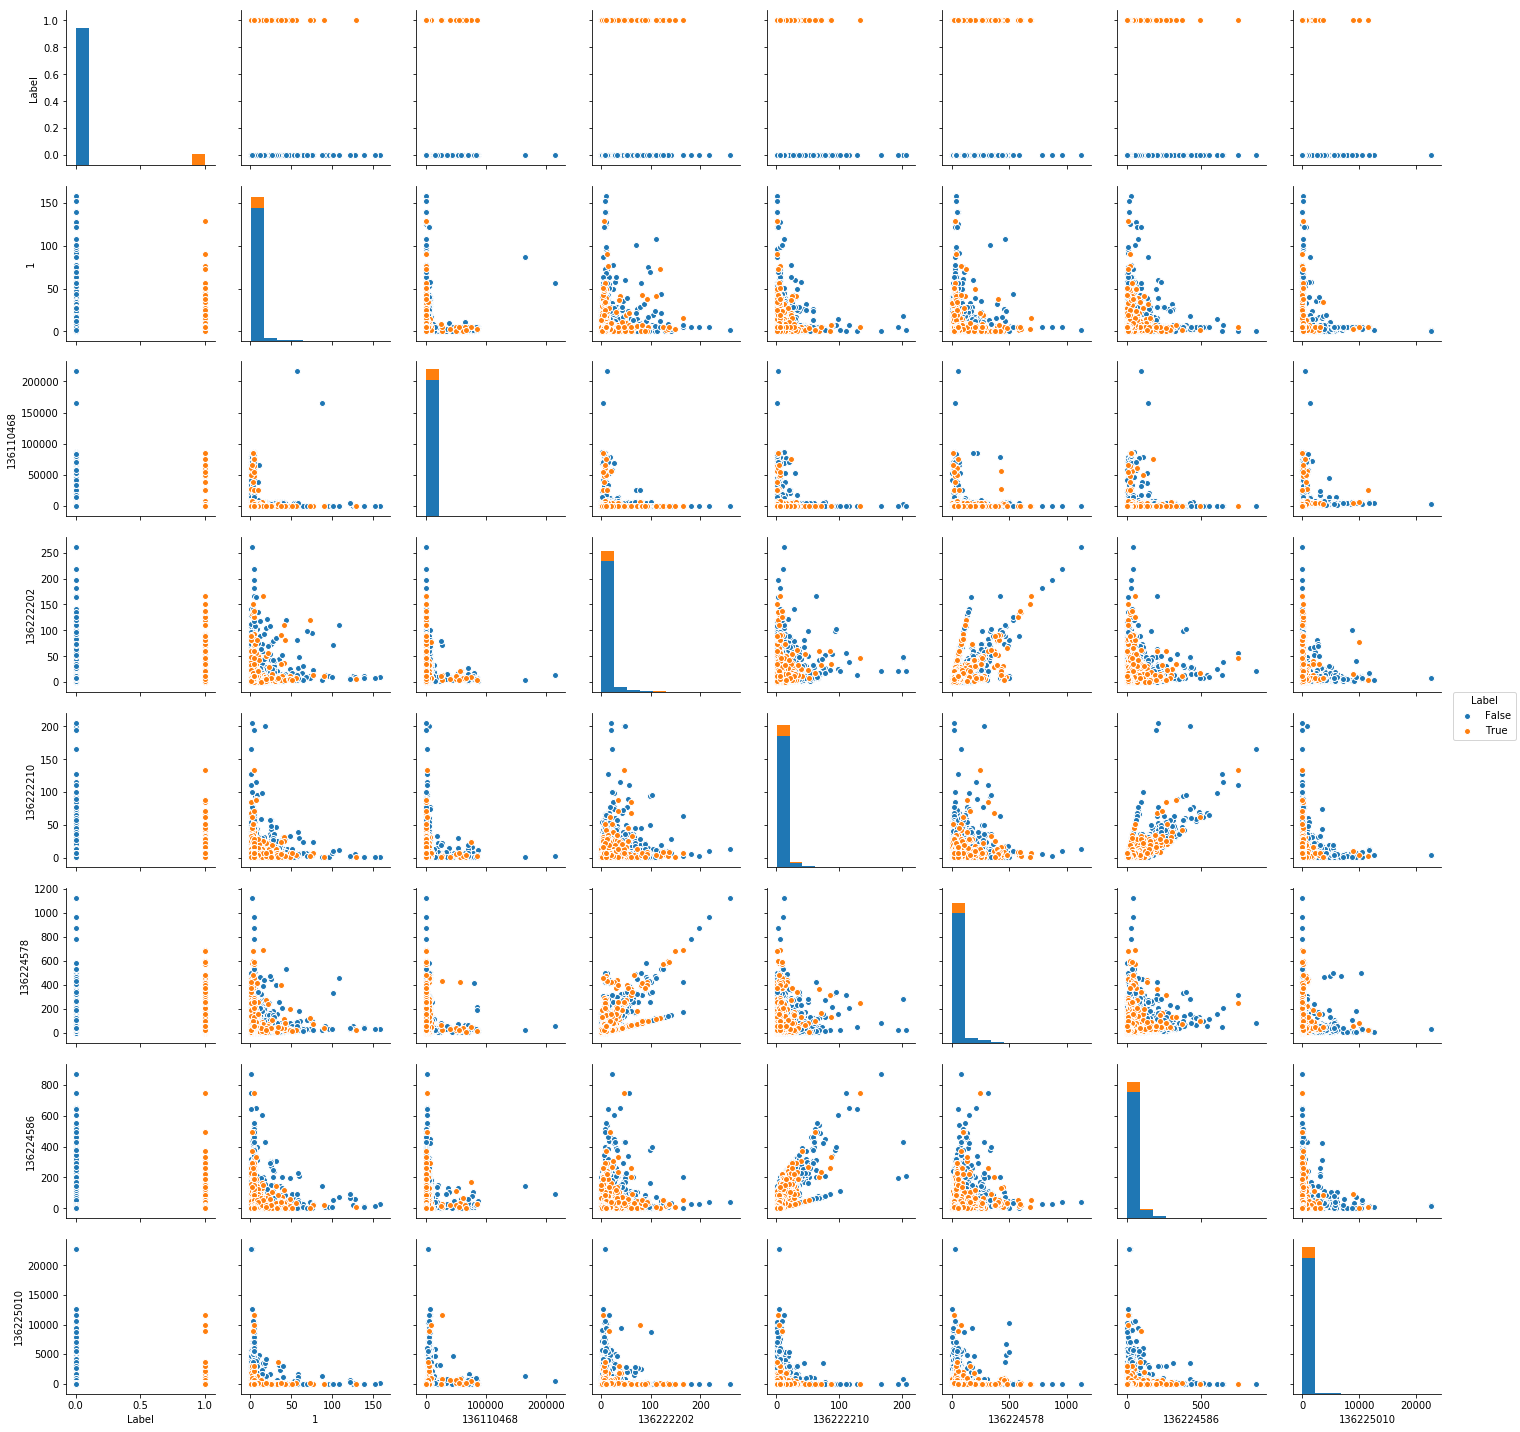

In [204]:
grid = sns.pairplot(tr[count],hue="Label")

The above seems to illustrate:
1. some error are less important than others: 136225010;
2. seems that a svm, if surviving the curse of dimensionality, could divide the thing pretty well.

Noticing that True sample aggregate at the lower left corner, it may be due to the fact that high error frequencies is rare instead of high error frequencies is good!!!

Explore further!

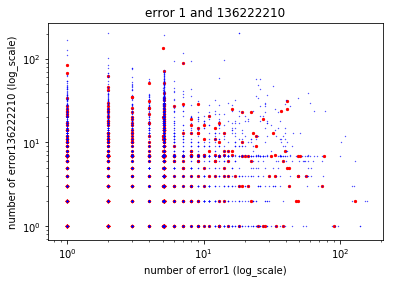

In [152]:
ax = plt.subplot(111)
ax.scatter(train_tr['1'],train_tr['136222210'],c='r',s=5,label='True')
ax.scatter(train_fl['1'],train_fl['136222210'],c='b',s=0.1,label='False')
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel('number of error1 (log_scale)')
plt.ylabel('number of error136222210 (log_scale)')
plt.title('error 1 and 136222210')
plt.show()

no discerable pattern found between the number of counts.
Further look at another group to support.

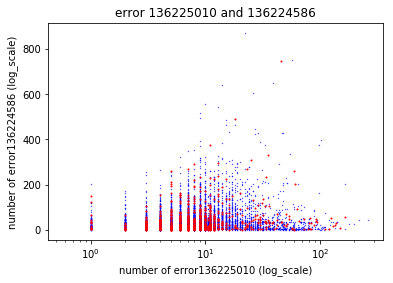

In [214]:
ax = plt.subplot(111)
ax.scatter(train_fl['136222202'],train_fl['136224586'],c='b',s=0.1,label='False')
ax.scatter(train_tr['136222202'],train_tr['136224586'],c='r',s=1,label='True')
ax.set_xscale('log')
# ax.set_yscale('log')
plt.xlabel('number of error136225010 (log_scale)')
plt.ylabel('number of error136224586 (log_scale)')
plt.title('error 136225010 and 136224586')
plt.show()

Since linearly not seperable, Do a polinomial regression to testify that 'count' does not work either in higher dimensionals space.
But this graph actually gives us something, which is emphasized later: the true break down have a smaller number of break down. Which is counter intuitive.

In [84]:
import statsmodels.api as sm

In [90]:
from sklearn import metrics
def plot_roc(pred,y):
    '''
    plotting roc curve
    '''
    fpr, tpr, threshold = metrics.roc_curve(y, pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [292]:
# have to downsample to avoid the skewness
zero = tr[count].sample(n=train_tr.shape[0],replace=False,axis=0)
linear_data = pd.concat([zero,train_tr[count]],axis=0)
linear_data = linear_data.sample(frac=1)
# fit the model
X = sm.add_constant(linear_data.loc[:,linear_data.columns!='Label'])
model = sm.OLS(linear_data['Label'],X).fit()
print(np.array(model.pvalues[1:]))

[3.35079269e-02 4.78683973e-01 3.87061563e-01 1.18417902e-01
 2.13286616e-04 2.97066756e-03 3.53618040e-01]


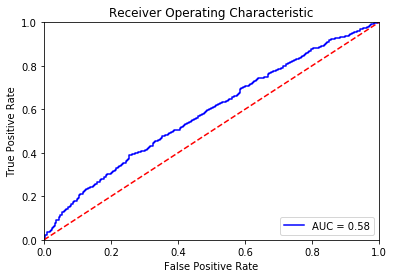

In [94]:
pred = model.predict(X)
plot_roc(pred,linear_data['Label'])

In [98]:
test_zero = tr[count].sample(n=train_tr.shape[0],replace=False,axis=0)
test_one = train_tr[count].sample(n=int(train_tr.shape[0]/10),replace=False,axis=0)
test_data = pd.concat([zero,test_one],axis=0)
test_X = sm.add_constant(test_data.loc[:,test_data.columns!='Label'])
pred = model.predict(test_X)

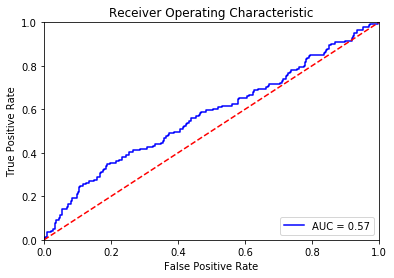

In [100]:
pred = model.predict(test_X)
plot_roc(pred,test_data['Label'])

In [101]:
# polynomial prediction may help

In [257]:
from sklearn.preprocessing import PolynomialFeatures

In [270]:
from sklearn import linear_model

In [293]:
logistic = linear_model.LogisticRegression()
logistic.fit(linear_data_poly, linear_data.iloc[:int(len(linear_data)*0.8),0])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

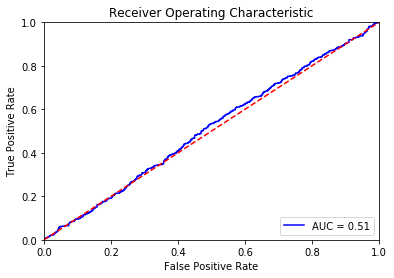

In [294]:
pred = logistic.predict_proba(linear_data_poly)[:,1]
plot_roc(pred,linear_data.iloc[:int(len(linear_data)*0.8),0])

In [295]:
poly = PolynomialFeatures(3)

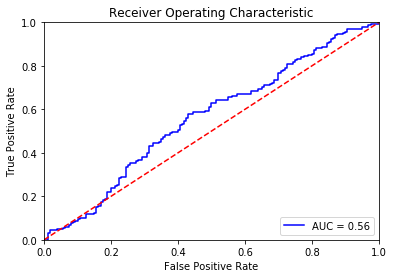

In [296]:
linear_data_val = poly.fit_transform(linear_data.iloc[int(len(linear_data)*0.8):,1:])
pred = logistic.predict_proba(linear_data_val)[:,1]
plot_roc(pred,linear_data.iloc[int(len(linear_data)*0.8):,0])

In [316]:
ts = ts.loc[:,[x for x in count]]
ts = ts.fillna(tr.mean())
ts_poly = poly.fit_transform(ts.iloc[:,1:])

In [322]:
pred = logistic.predict_proba(ts_poly)[:,1]
sample = pd.read_csv('./data/submission_sample.csv',header=0,index_col=[0])
sample['label']=pred
sample.to_csv('./data/submission.csv')

/home/elessar/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


### Count alone is not efficient at all

## The second natual guess is that maybe some error is more important then others.
## see if some errors along with its mean and var may yield better result 

In [ ]:
tr['error1_group'] = pd.cut(tr['1'],10,labels=range(10))

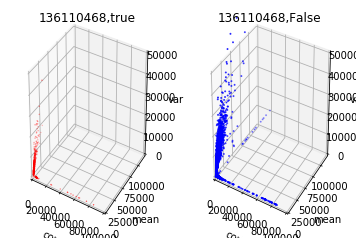

In [144]:
ax = plt.subplot(121, projection='3d')
# ax.scatter(train_fl['136110468'],train_fl['136110468.1'],train_fl['136110468.2'],c='b',s=1)
ax.scatter(train_tr['136110468'],train_tr['136110468.1'],train_tr['136110468.2'],c='r',s=0.1)
plt.title('136110468,true')
ax.set_xlabel('count')
ax.set_ylabel('mean')
ax.set_zlabel('var')
ax.set_xlim(0,100000)
ax.set_ylim(0,120000)
ax.set_zlim(0,50000)
ax = plt.subplot(122, projection='3d')
ax.scatter(train_fl['136110468'],train_fl['136110468.1'],train_fl['136110468.2'],c='b',s=1)
# ax.scatter(train_tr['136110468'],train_tr['136110468.1'],train_tr['136110468.2'],c='r',s=0.1)
plt.title('136110468,False')
ax.set_xlabel('count')
ax.set_ylabel('mean')
ax.set_zlabel('var')
ax.set_xlim(0,100000)
ax.set_ylim(0,120000)
ax.set_zlim(0,50000)
plt.show()

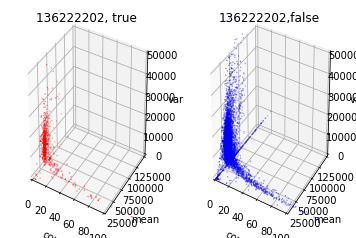

In [138]:
ax = plt.subplot(121, projection='3d')
# ax.scatter(train_fl['136222202'],train_fl['136222202.1'],train_fl['136222202.2'],c='b',s=0.1)
ax.scatter(train_tr['136222202'],train_tr['136222202.1'],train_tr['136222202.2'],c='r',s=0.1)
plt.title('136222202, true')
ax.set_xlim(0,100)
ax.set_ylim(2500,125000)
ax.set_zlim(0,50000)
ax.set_xlabel('count')
ax.set_ylabel('mean')
ax.set_zlabel('var')
ax = plt.subplot(122, projection='3d')
ax.scatter(train_fl['136222202'],train_fl['136222202.1'],train_fl['136222202.2'],c='b',s=0.1)
# ax.scatter(train_tr['136222202'],train_tr['136222202.1'],train_tr['136222202.2'],c='r',s=10)
plt.title('136222202,false')
ax.set_xlim(0,100)
ax.set_ylim(2500,125000)
ax.set_zlim(0,50000)
ax.set_xlabel('count')
ax.set_ylabel('mean')
ax.set_zlabel('var')
plt.show()

### Nice findings: For the True sample, count, mean and var are all in a smaller range than the False sample. This coinside with the count plot we see ealier. Let's have a closer look.

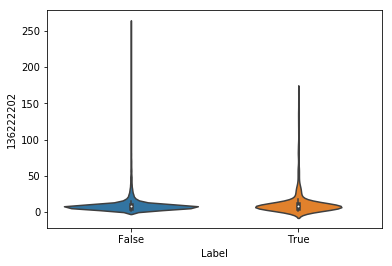

In [160]:
sns.violinplot("Label","136222202",data=tr)

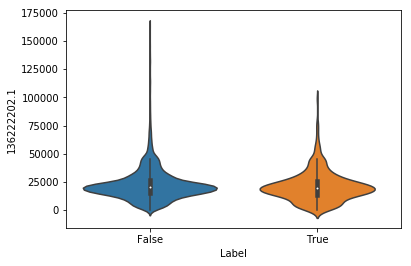

In [161]:
sns.violinplot("Label","136222202.1",data=tr)

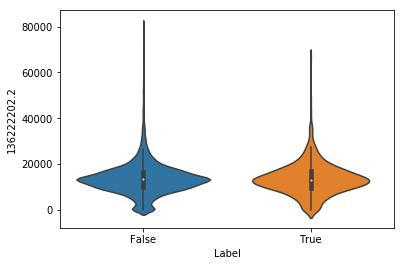

In [162]:
sns.violinplot("Label","136222202.2",data=tr)

the three graph above indicates that the above guesses could be wrong because of the data quantity.
Since there are only a frew true data, they naturally cover a smaller range. But follow a same distribution.

## Third guess: Notice that the rare break down somehow correlats with the true rate. The columns with a bunch of nan value can perhaps indicates a good result

In [208]:
tr_copy = tr.copy()
tr_copy.loc[tr['1'].apply(lambda x: x%1!=0),'1']= 200

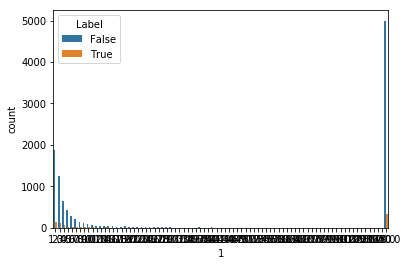

In [210]:
sns.countplot('1', hue = 'Label', data = tr_copy)

In [230]:
((tr_copy.loc[:,'Label']==True)&(tr_copy.loc[:,'1']<5)).sum()/train_tr.shape[0]

0.41203703703703703

In [231]:
((tr_copy.loc[:,'Label']==False)&(tr_copy.loc[:,'1']<5)).sum()/train_fl.shape[0]

0.3926043219076006

In [ ]:
# probability is not very different. Discard this hypothesis.

## Fourth way: when all ligts are gone, use the trees...

In [326]:
tr, ts = read_file('./data/train.csv','./data/verification.csv')
tr = tr.dropna(thresh=int(tr.shape[0]*0.5),axis=1)
tr = tr.dropna(thresh=int(tr.shape[1]*0.5),axis=0)
tr = tr.dropna(subset=['Label'])
tr = tr.fillna(tr.mean())
ts = ts.loc[:,[x for x in tr.columns]]
ts = ts.fillna(tr.mean())

/home/elessar/.local/lib/python3.5/site-packages/pandas/core/indexing.py:972: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


In [327]:
train_y = tr.loc[:'M065_A1','Label']
train_x = tr.loc[:'M065_A1',tr.columns!='Label']

train_val_y = tr.loc['M065_A1':,'Label']
train_val_x = tr.loc['M065_A1':,tr.columns!='Label']

test_x = ts.loc[:,ts.columns!='Label']

In [325]:
from sklearn.ensemble import GradientBoostingClassifier

In [333]:
clf = GradientBoostingClassifier(loss='deviance',n_estimators=100,learning_rate=1.0,max_depth=1,random_state=0).fit(train_x, train_y)

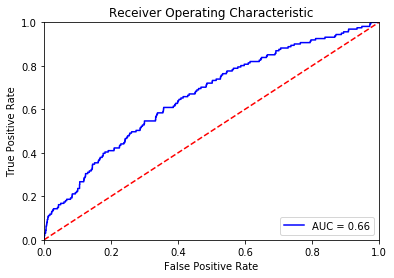

In [335]:
pred = clf.predict_proba(train_val_x)[:,1]
plot_roc(pred,train_val_y)

In [337]:
tuned_parameter = [{'learning_rate': [0.05,0.1,0.15,0.2],
                    'n_estimators': [100,200,300,400],
                    'max_depth': [1,2,3],
                    'subsample':[1,0.75,0.5]}]

In [338]:
from sklearn.grid_search import GridSearchCV 

/home/elessar/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/elessar/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [339]:
tree = GridSearchCV(GradientBoostingClassifier(loss='deviance',max_features='auto',random_state=0),
                    param_grid =tuned_parameter,scoring='roc_auc',cv=5)
tree.fit(tr.loc[:,tr.columns!='Label'],tr.loc[:,'Label'])

KeyboardInterrupt: 

In [ ]:
tree.best_params_

In [ ]:
pred = clf.predict_proba(test_x)[:,1]
sample = pd.read_csv('./data/submission_sample.csv',header=0,index_col=[0])
sample['label']=pred
sample.to_csv('./data/submission.csv')

## Fourth Guess: the label itself provides us with information. If machine broaken down, ampt to break down again in the near future. Use LSTM

In [ ]:
# To be completed